# Data Acquisition. 0 Data Structure of Files

In [1]:
# import missingno as msno

In [2]:
# all modules
import warnings
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import requests

import re

from datetime import datetime
from sklearn.preprocessing import OneHotEncoder

# from zipfile import ZipFile
from bs4 import BeautifulSoup

from functools import reduce

In [3]:
# global stuff
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

In [4]:
# load sql extension for jupyter
%load_ext sql
%config SqlMagic.autocommit = False

In [5]:
# load database
%sql sqlite:///../data/raw/raw_data_project_m1.db

In [6]:
%%sql tables_structure <<

select * 
from 
    sqlite_master

where 
    type='table' AND
    name NOT LIKE 'sqlite_%'

 * sqlite:///../data/raw/raw_data_project_m1.db
Done.
Returning data to local variable tables_structure


## OPENING TABLES

In [7]:
%%sql personal_info <<

select * from personal_info;

 * sqlite:///../data/raw/raw_data_project_m1.db
Done.
Returning data to local variable personal_info


In [8]:
%%sql country_info <<

select * from country_info;

 * sqlite:///../data/raw/raw_data_project_m1.db
Done.
Returning data to local variable country_info


In [9]:
%%sql career_info <<

select * from career_info;

 * sqlite:///../data/raw/raw_data_project_m1.db
Done.
Returning data to local variable career_info


In [10]:
%%sql poll_info <<

select * from poll_info;

 * sqlite:///../data/raw/raw_data_project_m1.db
Done.
Returning data to local variable poll_info


In [11]:
df_personal_info = personal_info.DataFrame()
df_country_info = country_info.DataFrame()
df_career_info = career_info.DataFrame()
df_poll_info = poll_info.DataFrame()

# WEB SCRAPPING

In [12]:
def get_dictCountries(web_page):
    """
    Note_1: Only works for a part of the web scrapping, therefore dict lenght is limited to countries_in_eu
    Note_2: 'https://ec.europa.eu/eurostat/statistics-explained/index.php/Glossary:Country_codes'
    ------------------------------------------------------------------------------------------------    
    INPUT: url
    OUTPUT: dict -> 'SP': 'Spain'

    """
    countries_in_europe = 45
        
    url= web_page
    html = requests.get(url).content

    soup = BeautifulSoup(html, 'lxml')
    table = soup.find_all('table')
    
    countries_list = list(filter(None, 
                                 [re.sub('\n','', re.sub('</td>','', re.sub('^<td>','', str(i)))) 
                                  for i in soup.find_all('td')]))

    """
    Note
    ------------------------------------------------------------------------------------------------
    Esta parte es mejorable: Kosovo* y CH_X_HK etc ...  
    """
    countries_names = [(''.join(i.strip())).split('<')[0] for k, i in enumerate(countries_list) if k%2 == 0]
    countries_alpha2= [(''.join(i.strip())).split('<')[0][1:3] for k, i in enumerate(countries_list) if k%2 != 0]
    
    countries_dict = dict(zip(countries_alpha2[:countries_in_europe], countries_names[:countries_in_europe]))
    

    """
    IMPERFECT IMPLEMENTATIONS (as seen in wikipedia)
    ------------------------------------------------------------------------------------------------
    The European Commission generally uses ISO 3166-1 alpha-2 codes with two exceptions: 
    EL (not GR) is used to represent Greece, and UK (not GB) is used to represent the United Kingdom
    """
    countries_dict = dict(zip(countries_alpha2[:countries_in_europe], countries_names[:countries_in_europe]))
    countries_dict['GB'] = 'United Kingdom'
    countries_dict['GR'] = 'Greece'

    return countries_dict

In [13]:
countries_dict = get_dictCountries('https://ec.europa.eu/eurostat/statistics-explained/index.php/Glossary:Country_codes')

In [14]:
# DICTIONARY TO REPLACE WITH WEB SCRAPPING

countries_code_alpha_2 = {
    'AT' : 'Austria',   'BE' : 'Belgium',        'BG' : 'Bulgaria',  'CY' : 'Cyprus',     'CZ' : 'Czechia',
    'DE' : 'Germany',   'DK' : 'Denmark',        'EE' : 'Estonia',   'ES' : 'Spain',      'FI' : 'Finland', 
    'FR' : 'France',    'GB' : 'United Kingdom', 'GR' : 'Greece',    'HR' : 'Croatia',    'HU' : 'Hungary', 
    'IE' : 'Ireland',   'IT' : 'Italy',          'LT' : 'Lithuania', 'LU' : 'Luxembourg', 'LV' : 'Latvia',  
    'MT' : 'Malta',     'NL' : 'Netherlands',    'PL' : 'Poland',    'PT' : 'Portugal',   'RO' : 'Romania',
    'SE' : 'Sweden',    'SI' : 'Slovenia',       'SK' : 'Slovakia',
} 
"""Hay 28 paises y me he sacado 45 de lap pag (TODA EUROPA) """ 

'Hay 28 paises y me he sacado 45 de lap pag (TODA EUROPA) '

In [15]:
def get_dictEuropeanCountries():
    wiki_url= 'https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2'
    url= 'https://www.euro.who.int/en/countries'
    
    html_wikipage = requests.get(wiki_url).content
    html_eurocountries = requests.get(url).content
        
    countries_list = pd.read_html(html_wikipage, header=0)[2]
    countries_dict = dict(zip(countries_list['Code'], countries_list['Country name (using title case)']))

    soup = BeautifulSoup(html_eurocountries, 'lxml')
    table = soup.find_all('section', {'class':'clearfix'})

    all_contries = [content.text for content in table]
    eu_countries = list(filter(None, all_contries[0].split('\n')))

    european_countries_values = [val for k,val in countries_dict.items() for eu_c in eu_countries if val == eu_c]
    european_countries_key = [k for k,val in countries_dict.items() for eu_c in eu_countries if val == eu_c]

    return dict(zip(european_countries_key, european_countries_values))

In [16]:
european_countries = get_dictEuropeanCountries()

In [17]:
european_countries

{'AD': 'Andorra',
 'AL': 'Albania',
 'AM': 'Armenia',
 'AT': 'Austria',
 'AZ': 'Azerbaijan',
 'BA': 'Bosnia and Herzegovina',
 'BE': 'Belgium',
 'BG': 'Bulgaria',
 'BY': 'Belarus',
 'CH': 'Switzerland',
 'CY': 'Cyprus',
 'CZ': 'Czechia',
 'DE': 'Germany',
 'DK': 'Denmark',
 'EE': 'Estonia',
 'ES': 'Spain',
 'FI': 'Finland',
 'FR': 'France',
 'GB': 'United Kingdom of Great Britain and Northern Ireland',
 'GE': 'Georgia',
 'GR': 'Greece',
 'HR': 'Croatia',
 'HU': 'Hungary',
 'IE': 'Ireland',
 'IL': 'Israel',
 'IS': 'Iceland',
 'IT': 'Italy',
 'KG': 'Kyrgyzstan',
 'KZ': 'Kazakhstan',
 'LT': 'Lithuania',
 'LU': 'Luxembourg',
 'LV': 'Latvia',
 'MC': 'Monaco',
 'ME': 'Montenegro',
 'MK': 'North Macedonia',
 'MT': 'Malta',
 'NL': 'Netherlands',
 'NO': 'Norway',
 'PL': 'Poland',
 'PT': 'Portugal',
 'RO': 'Romania',
 'RS': 'Serbia',
 'RU': 'Russian Federation',
 'SE': 'Sweden',
 'SI': 'Slovenia',
 'SK': 'Slovakia',
 'SM': 'San Marino',
 'TJ': 'Tajikistan',
 'TM': 'Turkmenistan',
 'TR': 'Turkey'

# FUNCTIONS

In [18]:
def ageStr_to_ageNum(serie):
    """
    INPUT -> serie df[] = ['61 years old', '57 years old', '32 years old'] -> full strings
    OUPUT -> serie df[] = [ 61 57 32 45 41 1990 2000]                      -> only integers
    """
    return serie.apply(lambda x: re.sub('\D', '', x)).astype(int)

def year_to_age(serie):
    """
    INPUT -> serie:  df[] = [ 61 57 32 45 41 1990 2000]   -> ages + years (all ints)
    OUTPUT -> serie: df[] = [ 61 57 32 45 41   30   20]   -> only ages    (all ints)
    """   
    year_db = 2016 # DB is from this year!
    return serie.apply(lambda x: year_db - x if int(x) > 200 else x)

def year_update(serie):
    """
    La tabla está en 2016, hay que actualizar datos para uqe no haya incongruencias entre Age y Age_Group
    """
    year_now = datetime.today().year
    year_db = 2016
    return serie.apply(lambda x: (year_now - year_db) + x)


def countryCode_to_countryName(serie, web_page):
    # CAMBIAR SEGÚN DICCIONARIO DE EUROPEAN COUNTRIES
    """
    INPUT  ->      AT      FR     ES  -> alpha_2 code
    OUTPUT -> Austria  France  Spain  -> full name
    --------------------------------------------------------------------------------
    Note: countries_code_alpha_2 is a dict from get_dictCountries()
    """
    url = web_page
    country_dictionary = get_dictCountries(url)
    
    return serie.apply(lambda x: country_dictionary[str(x)]) # Esto se puede hacer en la API


def null_to_unknown(serie):
    """
    INPUT  -> no  high     None  medium     None  low  no
    OUTPUT -> no  high  unknown  medium  unknown  low  no
    
    Podria considerarse tb no... aquí hay interpretación de datos!
    """
    return serie.apply(lambda x: 'unknown' if x == None else x)


def gender_homogenization(serie):
    """
    INPUT  -> female, FeMale, Fem, male, Male
    OUTPUT ->      F,      F,   F,    M,    M
    """
    serie = serie.apply(lambda x: re.sub('^f\w+|^F\w+', 'F', x))
    serie = serie.apply(lambda x: re.sub('^m\w+|^M\w+', 'M', x))
    return serie


def context_homogenization(serie):
    """
    INPUT  ->   urban  city  rural  Non-Rural Countryside  -> various types of response
    OUTPUT ->   urban  urban rural      urban       rural  -> two types of response
    ------------------------------------------------------------------------------------
    LIST OF POSSIBLE ANSWERS TAKING INTO ACCOUNT serie count values
    """
    urban_context = ['urban', 'city', 'non-rural', 'Non-Rural']
    rural_context = ['rural', 'country', 'countryside', 'Country']
    
    return  ['urban_context' if response in urban_context 
        else 'rural_context' if response in rural_context 
        else None 
        for response in serie]



def yes_no_to_bool(serie):
    """
    Appliable to yes/no questions with multiple formats, to transform into boolean info
    INPUT  -> YES yes Yes yES No NO nO no  -> type str
    OUTPUT ->   1   1   1   1  0  0  0  0  -> type bool
    """
    serie = serie.apply(lambda x: re.sub('^y\w+|^Y\w+', '1', x))
    serie = serie.apply(lambda x: re.sub('^n\w+|^N\w+', '0', x)).astype(int)
    return serie.astype(bool)



################################################################################# EJERCICIO DE API ####

def get_job_code(serie):
    """
    In table career_info
    INPUT  -> hash
    OUTPUT -> dictionary w hash info provided by API
    """
    json_dicts = []
    uuid_db = serie.unique().tolist()
    
    for job_code in uuid_db:
        response = requests.get(f'http://api.dataatwork.org/v1/jobs/{job_code}')
        json_dicts.append(response.json())
        
    return json_dicts


def normalized_jobs_col(coded_series, json_data):
    """
    INPUT  -> None  <hash>                 --> coded_col
    OUTPUT -> None  <job name as in API>   --> new_col
    """
    new_col = [d.get('title')  for job_code in coded_series 
                               for d in json_data 
                               if d.get('uuid') == job_code]
    # d.get('title') or d.get('normalized_job_title')
    return new_col  # Con aply or merge tb


################################################################################# SCKLEARN COSAS DE ML ####

def separate_df_to_bools(df, cols_to_separate, cols_separated):
    """
    INPUT  -> df[col].unique() = [range_1, range_2, range_3]
    OUTPUT -> df[[range_1, range_2, range_3]] with boolean responses
    """
    df_encoder = OneHotEncoder(dtype=bool, sparse=True)
    df = pd.DataFrame(df_encoder.fit_transform(df[cols_to_separate]).toarray(),columns=cols_separated)
    return df

### 1_ DF_PERSONAL_INFO

In [19]:
try:
    initial_cols = ['gender', 'age_group']
    final_cols = ['gender_Female', 'gender_Male', 'ageGroup_14_25', 'ageGroup_26_39', 'ageGroup_40_65', 'ageGroup_juvenile']
    
    # Paso 1_ normalización de columna Age: str -> int -> change years w/ ages -> update current year?
    df_personal_info['age'] = ageStr_to_ageNum(df_personal_info['age'])
    df_personal_info['age'] = year_to_age(df_personal_info['age'])
    # df_personal_info['age'] = year_update(df_personal_info['age'])
    """ El problema de actualizar la fecha es que hay que reevaluar los grupos de edad"""

    # Paso 2_ String Operations: multiple inputs in binomial cols -> only 2 values for 2 options
    df_personal_info['gender'] = gender_homogenization(df_personal_info['gender'])
    df_personal_info['dem_has_children'] = yes_no_to_bool(df_personal_info['dem_has_children'])
    
    # Paso 3_ Separate cols for boolean options
    new_bool_df = separate_df_to_bools(df_personal_info, initial_cols, final_cols)
    df_personal_info = df_personal_info.join(other= new_bool_df, on=None, how='left', sort=False)
    
except:
    print('Something went wrong')

finally:
    """ MEMORY USAGE from 377.0+ KB to 367.6+ KB | FROM object(5) to bool(7), object(4) """
    print('Done cleaning df_personal_info!')

Done cleaning df_personal_info!


In [20]:
df_personal_info.head(3)

,uuid,age,gender,dem_has_children,age_group,gender_Female,gender_Male,ageGroup_14_25,ageGroup_26_39,ageGroup_40_65,ageGroup_juvenile
0,f6e7ee00-deac-0133-4de8-0a81e8b09a82,61,M,False,40_65,False,True,False,False,True,False
1,54f0f1c0-dda1-0133-a559-0a81e8b09a82,57,M,True,40_65,False,True,False,False,True,False
2,83127080-da3d-0133-c74f-0a81e8b09a82,32,M,False,26_39,False,True,False,True,False,False


### 2_ DF COUNTRY_INFO 

In [21]:
try:
    initial_cols = ['rural']
    final_cols = ['rural_context', 'urban_context']
    
    ### Here comes the dict from web scrapping
    
    # Paso 1_ transformar datos en cols en elementos más legibles
    df_country_info['country_Names'] = countryCode_to_countryName(
        serie= df_country_info['country_code'], 
        web_page= 'https://ec.europa.eu/eurostat/statistics-explained/index.php/Glossary:Country_codes')
    
    df_country_info['rural'] = context_homogenization(df_country_info['rural'])
    
    # Paso 2_
    new_bool_df = separate_df_to_bools(df_country_info, initial_cols, final_cols)
    
    df_country_info = df_country_info.join(other= new_bool_df, on=None, 
                                                               how='left', 
                                                               sort=False)

    df_country_info.drop(columns='rural', inplace = True)
    
except:
    pass

finally:
    """ MEMORY USAGE from 226.3+ KB to 169.70+ KB | FROM object(3) to bool(2), object(2) """
    print('Done cleaning df_country_info!')

Done cleaning df_country_info!


In [22]:
df_country_info.head(3)

,uuid,country_code,country_Names,rural_context,urban_context
0,f6e7ee00-deac-0133-4de8-0a81e8b09a82,AT,Austria,True,False
1,54f0f1c0-dda1-0133-a559-0a81e8b09a82,AT,Austria,False,True
2,83127080-da3d-0133-c74f-0a81e8b09a82,AT,Austria,False,True


### 3_ DF CAREER_INFO 

In [23]:
try:
    # Columnas a separar en booleanos
    initial_cols  = ['dem_education_level']
    final_cols = ['High_Ed', 'Low_Ed', 'Medium_Ed', 'No_Ed', 'Unknown_Ed']

    # Paso 1_ cambiar columnas de yes/no -> booleanos + Nones to Unknown en col de valores cualitativos
    df_career_info['dem_full_time_job'] = yes_no_to_bool(df_career_info['dem_full_time_job'])
    df_career_info['dem_education_level'] = null_to_unknown(df_career_info['dem_education_level'])
    
    # Paso 2_ A traves de API, añadir columna de nombres de JOBS
    json_job_data = get_job_code(df_career_info['normalized_job_code'])
    df_career_info['normalized_job_name'] = normalized_jobs_col(df_career_info['normalized_job_code'], json_job_data)
    
    # Paso 3_ Creación de nuevas columnas, a partir de columna inicial
    new_bool_df = separate_df_to_bools(df_career_info, initial_cols, final_cols)
    df_career_info = df_career_info.join(other= new_bool_df, on=None, how='left', sort=False)

    # Paso 4_ Eliminación de información redundante
    cols_to_del = ['dem_education_level', 'normalized_job_code']
    df_career_info.drop(columns= cols_to_del, inplace= True)
    
except:
    pass

finally:
    """MEMORY USAGE from 301.7+ KB to 207.4+ KB | FROM objects(4) to bool(6), object(2) """
    print('Done cleaning df_career_info!')

Done cleaning df_career_info!


In [24]:
df_career_info.head(10)

,uuid,dem_full_time_job,normalized_job_name,High_Ed,Low_Ed,Medium_Ed,No_Ed,Unknown_Ed
0,f6e7ee00-deac-0133-4de8-0a81e8b09a82,False,None,False,False,False,True,False
1,54f0f1c0-dda1-0133-a559-0a81e8b09a82,True,Automatic Data Processing Planner,True,False,False,False,False
2,83127080-da3d-0133-c74f-0a81e8b09a82,False,None,False,False,False,False,True
3,15626d40-db13-0133-ea5c-0a81e8b09a82,True,Data Coordinator,True,False,False,False,False
4,24954a70-db98-0133-4a64-0a81e8b09a82,True,Database Developer,True,False,False,False,False
5,28583060-dbe2-0133-ff9c-0a81e8b09a82,True,Data Entry Specialist,True,False,False,False,False
6,b50dbb80-da53-0133-8956-0a81e8b09a82,False,None,False,False,True,False,False
7,dd743bb0-d9a5-0133-53b2-0a81e8b09a82,True,Database Architect,False,False,True,False,False
8,4fde2370-da48-0133-3a42-0a81e8b09a82,True,Geographic Information Systems Database Admini...,False,False,True,False,False
9,9949c4c0-da5f-0133-c832-0a81e8b09a82,False,None,False,False,False,True,False


## 4_ DF POLL_INFO 

In [25]:
# df_poll_info.info()
""" dtypes: object(6) | memory usage: 452.4+ KB """

' dtypes: object(6) | memory usage: 452.4+ KB '

In [26]:
def split_str_at_char(str_to_split, cutter):
    if isinstance(str_to_split, str) and isinstance(cutter, str):
        return re.split(cutter, str_to_split)[1].capitalize()
    else:
        print('EntryError [at split_str_at_char]: wrong type of inputs')
    
def get_uniqueResponses(serie, separator):
    """
    This function searches for the uniques responses in a multiple choice response 
    presented as a concatenated string.
    INPUT  ->  'E | F | C | D'   'D | A'    'C'   'E | B'  --> Unsorted concat strings
    OUTPUT ->  ['E', 'F', 'C', 'D', 'A', 'B']              --> Unsorted unique strings
        
    """
    try:
        if isinstance(separator, str):
            list_of_all_responses = set()
            all_responses = set()

            flattened_list_of_responses = reduce(lambda x,y: x+y, 
                                                 [item.split(separator) for item in serie.unique()])

            for response in flattened_list_of_responses:
                if response not in list_of_all_responses:
                    list_of_all_responses.add(response)

            return list(list_of_all_responses)
        else:
            print('EntryError [at get_uniqueResponses]: wrong type of inputs')
        
    except:
        pass

def binary_equals(i, list_uniques, list_to_search):
    """
    This function iterates through a list and searches for equalities into another list.
    INPUT  -> [1,2,5,1,2,1,2,5]  + [1,2]   --> these are the lenghts of strings to search for equals
    OUTPUT -> [1,0,0,1,0,1,0,0]    [1]     --> equality in string of len = 1
              [0,1,0,0,1,0,1,0]    [2]     --> equality in string of len = 2
    ----------------------------------------------------------------------------------------
    IMPORTANT NOTE: This function only works as long as unique values have different lenghts!
    """
    
    try:
        if len(list_uniques) == len(set(len(list_uniques))):
            # First thing is to check that list lenghts between list and set of lenghts integer are the same
            
            list_index = len(list_to_search[i])
            list_of_equals = [1 if len(resp) == list_index else 0 for resp in list_uniques]
            
            return list_of_equals

        else:
            print("FatalError [at search_equals]: duplicated lenght of unique strings")

    except:
        pass

            
def binary_matrix(list_uniques, list_to_search):
    list_of_lists = []

    for i in range(len(list_to_search)):
        list_of_lists.append(binary_equals(i, list_uniques, list_to_search))
        
    return list(np.sum(list_of_lists, axis = 0))

In [27]:
def multiple_choice_col_to_DF(serie, separator):
    ser = serie
    sep = separator
    
    poll_info_allResponses = get_uniqueResponses(ser, sep)
    graph_list_of_responses = ser.apply(lambda x: x.split(sep))

    binary_series = graph_list_of_responses.apply(lambda x: binary_matrix(poll_info_allResponses, x))
    binary_dict = dict(zip(binary_series.index, binary_series.values))

    binary_df = pd.DataFrame.from_dict(binary_dict, orient='index', columns= poll_info_allResponses)
    
    new_col = df_poll_info['uuid']  # can be a list, a Series, an array or a scalar   
    binary_df.insert(loc=0, column='uuid', value=new_col)

    return binary_df

In [28]:
df_poll_info['question_bbi_2016wave4_basicincome_effect'] = [split_str_at_char(response, 'Û_ ') 
                                                            if re.search('Û_ ', response)
                                                            else response
                                                            for response in df_poll_info['question_bbi_2016wave4_basicincome_effect']
                                                            ]

################################################################################################################

################################################################################################################

FALTA AÑADIR LA COLUMNA DE UUID

In [29]:
"""

#df_poll_basicincome_awareness = multiple_choice_col_to_DF(df_poll_info['question_bbi_2016wave4_basicincome_awareness'], 
  #                                                              separator = ' | ')

#df_poll_basicincome_vote = multiple_choice_col_to_DF(df_poll_info['question_bbi_2016wave4_basicincome_vote'], 
 #                                                               separator = ' | ')

df_poll_basicincome_effect = multiple_choice_col_to_DF(df_poll_info['question_bbi_2016wave4_basicincome_effect'], 
                                                                separator = ' | ')


df_poll_basicincome_argumentsagainst = multiple_choice_col_to_DF(df_poll_info['question_bbi_2016wave4_basicincome_argumentsagainst'], 
                                                                separator = ' | ')


df_poll_basicincome_argumentsfor = multiple_choice_col_to_DF(df_poll_info['question_bbi_2016wave4_basicincome_argumentsfor'], separator = '|')

"""

"\n\n#df_poll_basicincome_awareness = multiple_choice_col_to_DF(df_poll_info['question_bbi_2016wave4_basicincome_awareness'], \n  #                                                              separator = ' | ')\n\n#df_poll_basicincome_vote = multiple_choice_col_to_DF(df_poll_info['question_bbi_2016wave4_basicincome_vote'], \n #                                                               separator = ' | ')\n\ndf_poll_basicincome_effect = multiple_choice_col_to_DF(df_poll_info['question_bbi_2016wave4_basicincome_effect'], \n                                                                separator = ' | ')\n\n\ndf_poll_basicincome_argumentsagainst = multiple_choice_col_to_DF(df_poll_info['question_bbi_2016wave4_basicincome_argumentsagainst'], \n                                                                separator = ' | ')\n\n\ndf_poll_basicincome_argumentsfor = multiple_choice_col_to_DF(df_poll_info['question_bbi_2016wave4_basicincome_argumentsfor'], separator = '|')\n\n"

In [30]:
df_poll_basicincome_awareness.head(3)

NameError: name 'df_poll_basicincome_awareness' is not defined

In [ ]:
df_poll_basicincome_vote.head(3)

In [ ]:
df_poll_basicincome_effect.head(3)

In [ ]:
df_poll_basicincome_argumentsfor.head(3)

In [ ]:
df_poll_basicincome_argumentsfor.shape

In [ ]:
df_poll_basicincome_argumentsagainst.head(10)

In [ ]:
df_poll_basicincome_argumentsagainst.shape

################################################################################################################

## TABLAS FINAL LIMPIADAS

Exportar tablas en LOCAL para poder hacer wrangling con ellas

In [ ]:
"""
df_personal_info

df_country_info

df_career_info

df_poll_basicincome_awareness
df_poll_basicincome_vote
df_poll_basicincome_effect
df_poll_basicincom_argumentsfor
df_poll_basicincome_argumentsagainst

"""

In [31]:
df_career_info.head(2)

,uuid,dem_full_time_job,normalized_job_name,High_Ed,Low_Ed,Medium_Ed,No_Ed,Unknown_Ed
0,f6e7ee00-deac-0133-4de8-0a81e8b09a82,False,None,False,False,False,True,False
1,54f0f1c0-dda1-0133-a559-0a81e8b09a82,True,Automatic Data Processing Planner,True,False,False,False,False


In [32]:
df_country_info.head(2)

,uuid,country_code,country_Names,rural_context,urban_context
0,f6e7ee00-deac-0133-4de8-0a81e8b09a82,AT,Austria,True,False
1,54f0f1c0-dda1-0133-a559-0a81e8b09a82,AT,Austria,False,True


In [33]:
df_personal_info.head(2)

,uuid,age,gender,dem_has_children,age_group,gender_Female,gender_Male,ageGroup_14_25,ageGroup_26_39,ageGroup_40_65,ageGroup_juvenile
0,f6e7ee00-deac-0133-4de8-0a81e8b09a82,61,M,False,40_65,False,True,False,False,True,False
1,54f0f1c0-dda1-0133-a559-0a81e8b09a82,57,M,True,40_65,False,True,False,False,True,False


In [34]:
dfs = [df_career_info, df_country_info, df_personal_info]
df_joined = reduce(lambda left,right: pd.merge(left,right,on='uuid'), dfs) #Apply
df_final = df_joined[['country_Names', 'normalized_job_name', 'gender', 'dem_full_time_job']]

In [35]:
df_final

,country_Names,normalized_job_name,gender,dem_full_time_job
0,Austria,None,M,False
1,Austria,Automatic Data Processing Planner,M,True
2,Austria,None,M,False
3,Austria,Data Coordinator,M,True
4,Austria,Database Developer,F,True
...,...,...,...,...
9644,Slovakia,Data Warehouse Developer,F,True
9645,Slovakia,Database Manager,M,True
9646,Slovakia,None,M,False
9647,Slovakia,Data Officer,M,True


In [36]:
####### ESTO ES MI DIVIDENDO: La cantidad de gente con un determinado trabajo en un país, dividido por sexos

df_2 = df_final.groupby(['country_Names','normalized_job_name','gender']).agg('count').reset_index()
df_2.rename(columns={"dem_full_time_job": "Quantity"}, inplace=True)



In [69]:
df_aux = df_2.assign(dummy = 1).groupby(['dummy','country_Names']).nunique()

In [70]:
df_aux

country_Names  normalized_job_name  gender  Quantity  \
dummy country_Names                                                          
1     Austria                     1                   50       2         3   
      Belgium                     1                   64       2         3   
      Bulgaria                    1                   63       2         5   
      Croatia                     1                   38       2         2   
      Cyprus                      1                    8       2         1   
...                             ...                  ...     ...       ...   
      Slovakia                    1                   44       2         3   
      Slovenia                    1                   17       2         1   
      Spain                       1                  128       2         9   
      Sweden                      1                   67       2         3   
      United Kingdom              1                  132       2        10   

                      dummy  
dummy country_Names          
1     Austria             1  
      Belgium             1  
      Bulgaria            1  
      Croatia             1  
      Cyprus              1  
...                     ...  
      Slovakia            1  
      Slovenia            1  
      Spain               1  
      Sweden              1  
      United Kingdom      1  

[28 rows x 5 columns]

In [87]:
###### ESTO ES MI DIVIDOR: La cantidad de gente encuestada por pais


df_4 = df_2.groupby(['country_Names'])['normalized_job_name'].nunique()
df_5 = df_2.groupby(['country_Names', 'gender'], as_index = False)['normalized_job_name','Quantity'].agg('count')

In [88]:
df_5.drop(columns='normalized_job_name', inplace=True, errors='raise')
df_5 = df_5.rename(columns = {'Quantity': 'totals_per_gender'})

In [89]:
df_5

,country_Names,gender,totals_per_gender
0,Austria,F,22
1,Austria,M,38
2,Belgium,F,30
3,Belgium,M,49
4,Bulgaria,F,36
...,...,...,...
51,Spain,M,113
52,Sweden,F,37
53,Sweden,M,41
54,United Kingdom,F,102


In [38]:
df_2.head(2)

,country_Names,normalized_job_name,gender,Quantity
0,Austria,Automatic Data Processing Customer Liaison (AD...,M,2
1,Austria,Automatic Data Processing Planner,F,1


In [97]:
df_4 = df_4.to_frame()
df_4 = df_4.rename(columns={'normalized_job_name': 'totals_per_country'})

In [98]:
df_5.head()

,country_Names,gender,totals_per_gender
0,Austria,F,22
1,Austria,M,38
2,Belgium,F,30
3,Belgium,M,49
4,Bulgaria,F,36


In [99]:
df_4.shape

(28, 1)

In [100]:
df_2.head(3)

,country_Names,normalized_job_name,gender,Quantity
0,Austria,Automatic Data Processing Customer Liaison (AD...,M,2
1,Austria,Automatic Data Processing Planner,F,1
2,Austria,Automatic Data Processing Planner,M,1


In [101]:
df_all = df_2.join(df_4, on='country_Names', how='left')

In [107]:
df_all_2 = df_5.join(df_4, on='country_Names', how= 'left')

In [108]:
df_all_2

,country_Names,gender,totals_per_gender,totals_per_country
0,Austria,F,22,50
1,Austria,M,38,50
2,Belgium,F,30,64
3,Belgium,M,49,64
4,Bulgaria,F,36,63
...,...,...,...,...
51,Spain,M,113,128
52,Sweden,F,37,67
53,Sweden,M,41,67
54,United Kingdom,F,102,132


In [105]:
filtr = df_all['country_Names'] == 'France'
df_all[filtr]

,country_Names,normalized_job_name,gender,Quantity,totals_per_country
506,France,Analytical Data Miner,F,1,123
507,France,Analytical Data Miner,M,1,123
508,France,Automatic Data Processing Customer Liaison (AD...,F,1,123
509,France,Automatic Data Processing Customer Liaison (AD...,M,10,123
510,France,Automatic Data Processing Planner,F,6,123
...,...,...,...,...,...
706,France,SQL Database Administrator,M,2,123
707,France,Scientific Database Curator,F,1,123
708,France,Scientific Database Curator,M,1,123
709,France,Survey Data Technician,F,1,123


In [44]:
df_all['Percentage'] = round(df_all['Quantity'] / df_all['totals_per_country'] * 100, 2)
df_filtr = df_all[filtr]

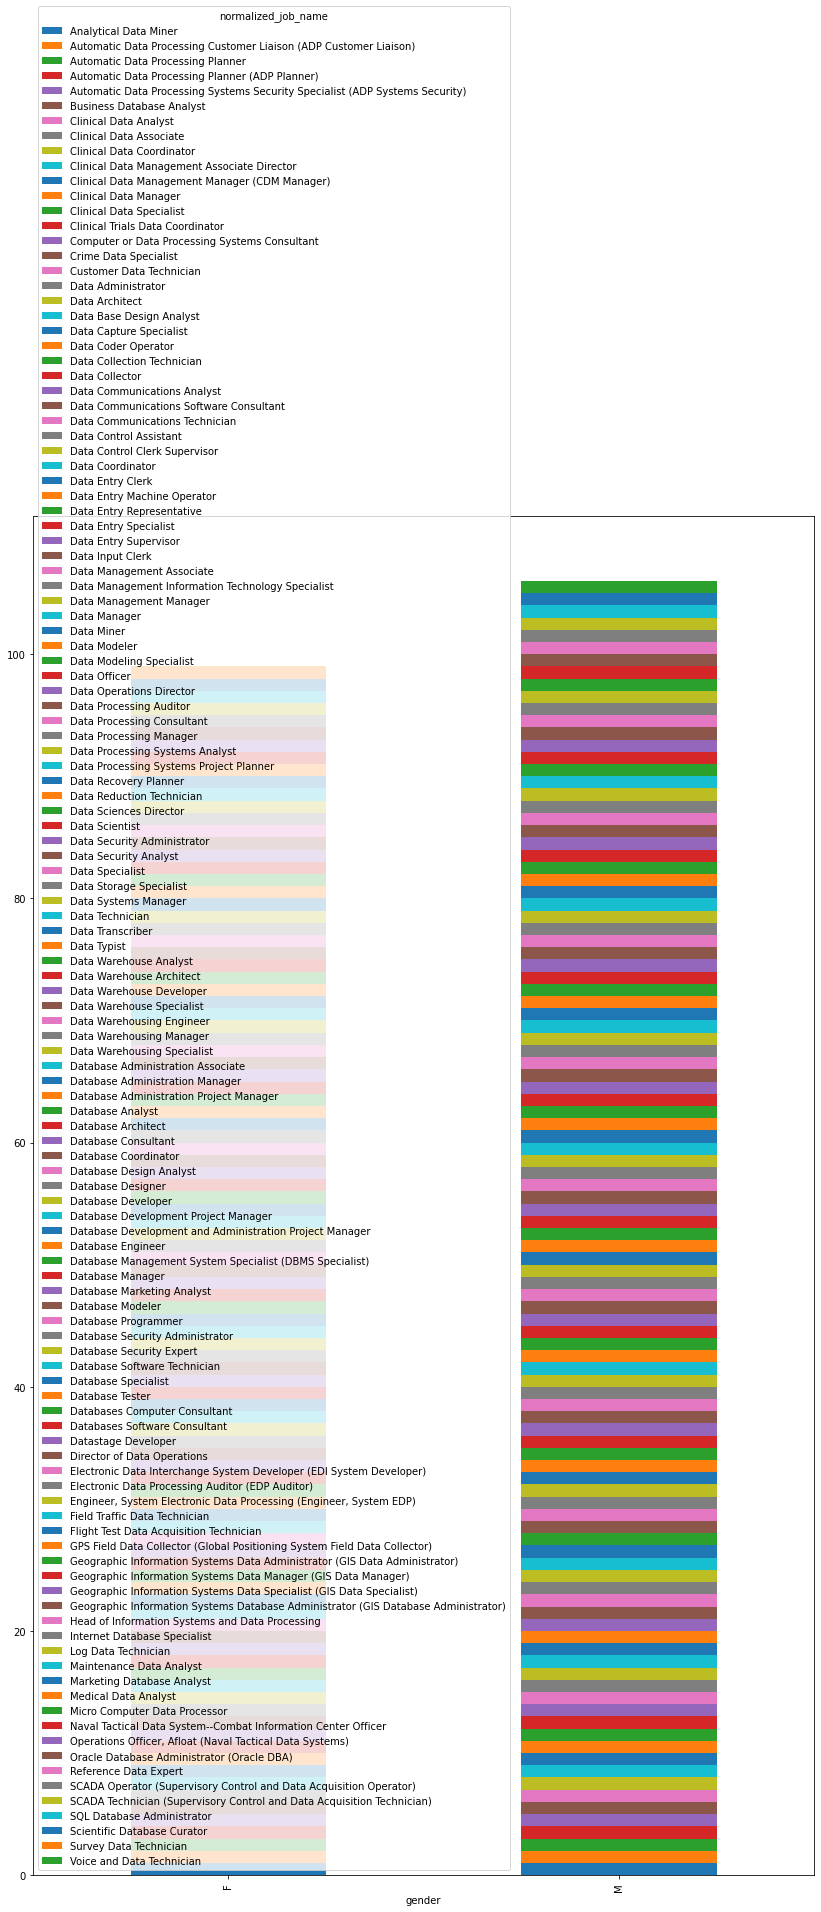

In [121]:
### CHART 1

# Tabla que muestra distribución según sexos de empleos (por país)
# Falta por trabajar que me muestre la cantidad, no su existencia
"""
df_filtr.groupby(['gender', 'normalized_job_name']).size().unstack().plot(kind='bar',stacked=True, figsize=(14, 25))
plt.show()
"""

In [126]:
"""
df_filtr.plot(kind='bar',x='normalized_job_name',y='Percentage')
plt.show()
"""

"\ndf_filtr.plot(kind='bar',x='normalized_job_name',y='Percentage')\nplt.show()\n"